# Dependencies

In [ ]:
import pkg_resources
import sys
import subprocess

# List of required packages (use package names as recognized by pip)
required = {
    'geopandas',
    'osmnx',
    'contextily',
    'libpysal',
    'esda',
    'pointpats',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'geodatasets',
    'folium',
    'pointpats'
}

# Get the set of installed packages
installed = {pkg.key for pkg in pkg_resources.working_set}
# Determine which packages are missing
missing = required - installed

if missing:
    print(f"Installing missing packages: {missing}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
else:
    print("All required packages are already installed.")

# Python imports

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import osmnx as ox
from shapely.geometry import Point, Polygon, shape
from shapely.wkt import loads
from libpysal.weights import Queen
import libpysal
from esda import Moran, Moran_Local
import esda
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import os
import warnings
from scipy.stats import gaussian_kde
import contextily as ctx
import re
import folium
from folium.plugins import HeatMap, MarkerCluster, GroupedLayerControl
from difflib import SequenceMatcher
from IPython.display import Markdown, display
from pointpats.distance_statistics import k, f, g, l, k_test, l_test  # For Ripley's alphabet
import pointpats
from pointpats import distance_statistics # Redundant if specific functions are imported, but harmless
import geodatasets
import branca.colormap as cm
import branca
from branca.element import Template, MacroElement, Element

# Data collection

In [ ]:
# use this to get data from cityofnewyork.us
def load_data(url, filename, usecols=None):
    """
    Downloads a CSV file from a given URL and loads it into a DataFrame.
    """
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        df = pd.read_csv(url, usecols=usecols)
        df.to_csv(filename, index=False)
    else:
        print(f"Loading {filename} from local file...")
        df = pd.read_csv(filename, usecols=usecols)
    return df

# all our data sources use this CRS
CRS_LOAD = "EPSG:4326" # use this for loading
# Web Mercator: According to gpt: Units = meters, and it is commonly used.
CRS_METERS = 3857 # convert to this after loading

## Crime data

In [ ]:
crime_data_path = "./data/NYPD_Complaint_Data_Historic.csv"
crime_data_url = "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"
crime_cols = ["CMPLNT_FR_DT", "LAW_CAT_CD", "BORO_NM", "ADDR_PCT_CD", "Latitude", "Longitude"]

crime_df = load_data(crime_data_url, crime_data_path, usecols=crime_cols)

# Convert dates to datetime. Parse errors will set value to NaT
crime_df["CMPLNT_FR_DT"] = pd.to_datetime(crime_df["CMPLNT_FR_DT"], format="%m/%d/%Y", errors='coerce')

# Filter for year 2019
crime_df = crime_df[crime_df["CMPLNT_FR_DT"].dt.year == 2019]

# Drop records with missing or invalid coordinates
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])
crime_df = crime_df[crime_df["Latitude"] != 0]

# Only keep relevant columns
crime_df = crime_df[["LAW_CAT_CD", "Latitude", "Longitude"]]

# convert to geodataframe
crime_gdf = gpd.GeoDataFrame(
    crime_df,
    geometry=gpd.points_from_xy(crime_df["Longitude"], crime_df["Latitude"]),
    crs=CRS_LOAD,
).to_crs(CRS_METERS)

print(f"Total records in 2019: {len(crime_df)}")
crime_gdf.head(3)

## Population by Neighbourhood tabulation areas (NTA) data

In [ ]:
# 1) Load NTA polygons
nta_polys_data_path = "./data/NYC_NTA_Polygons.csv"
nta_polys_data_url  = "https://data.cityofnewyork.us/api/views/9nt8-h7nd/rows.csv?accessType=DOWNLOAD"
nta_polys_df = load_data(nta_polys_data_url, nta_polys_data_path)

# 2) Convert to GeoDataFrame
nta_polys_gdf = gpd.GeoDataFrame(
    nta_polys_df,
    geometry=nta_polys_df["the_geom"].apply(loads),
    crs=CRS_LOAD,
).to_crs(CRS_METERS)

# 3) Load NTA population table
nta_pop_data_path = "./data/NYC_NTA.csv"
nta_pop_data_url  = "https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD"
nta_pop_df = load_data(nta_pop_data_url, nta_pop_data_path)

# Merge NTA's on prefix and substring

In [ ]:




# 4) Normalize population DataFrame columns, keep its Borough
nta_pop_for_merge = nta_pop_df.rename(columns={
    "NTA Code":   "NTA2020",
    "Population": "population",
    "NTA Name":   "NTAName_pop",
    "Borough":    "Borough_pop",
})

# 5) Merge population *and* Borough_pop onto the polys GDF
nta_polys_for_merge = nta_polys_gdf.merge(
    nta_pop_for_merge[["NTA2020", "population", "Borough_pop"]],
    on="NTA2020",
    how="left"
)

# 6) Rename the polygons’ own borough column for clarity
nta_polys_for_merge = nta_polys_for_merge.rename(columns={
    "BoroName": "BoroName_poly"
})

# 7) Remove any NTA whose name ends with "Park" or "park"
nta_polys_for_merge = nta_polys_for_merge[
    ~nta_polys_for_merge["NTAName"].str.lower().str.endswith("park")
].copy()

# 8) Pre‐compute lookup maps
poly_boro_map = nta_polys_for_merge.set_index("NTAName")["BoroName_poly"].to_dict()
pop_lookup    = nta_pop_for_merge.set_index("NTAName_pop")[["population","Borough_pop"]].to_dict()

# 9) Exact‐name fallback for population *only if boroughs match*
nta_pop_for_merge["NTAName_lc"]    = nta_pop_for_merge["NTAName_pop"].str.lower()
nta_polys_for_merge["NTAName_lc"] = nta_polys_for_merge["NTAName"].str.lower()
mask_missing = nta_polys_for_merge["population"].isna()

for idx in nta_polys_for_merge[mask_missing].index:
    raw      = nta_polys_for_merge.at[idx, "NTAName"]
    key      = nta_polys_for_merge.at[idx, "NTAName_lc"]
    raw_boro = poly_boro_map.get(raw)
    if key in pop_lookup and pop_lookup[key]["Borough_pop"] == raw_boro:
        nta_polys_for_merge.at[idx, "population"]  = pop_lookup[key]["population"]
        nta_polys_for_merge.at[idx, "Borough_pop"] = pop_lookup[key]["Borough_pop"]

nta_polys_for_merge = nta_polys_for_merge.drop(columns="NTAName_lc")

# 10) Record initial unmatched set
initial_unmatched = nta_polys_for_merge[nta_polys_for_merge["population"].isna()].copy()
initial_count     = len(initial_unmatched)

# 11) Helpers for fuzzy matching
def normalize_string(s: str) -> str:
    cleaned   = re.sub(r'[^A-Za-z0-9 ]+', ' ', s)
    collapsed = re.sub(r'\s+', ' ', cleaned)
    return collapsed.strip().lower()

def common_prefix_len(a: str, b: str) -> int:
    for i in range(min(len(a), len(b))):
        if a[i] != b[i]:
            return i
    return min(len(a), len(b))

def substring_match_len(a: str, b: str) -> int:
    matcher = SequenceMatcher(None, a, b)
    match   = matcher.find_longest_match(0, len(a), 0, len(b))
    return match.size

pop_names    = nta_pop_for_merge["NTAName_pop"].tolist()
name_to_pop  = nta_pop_for_merge.set_index("NTAName_pop")["population"].to_dict()
name_to_boro = nta_pop_for_merge.set_index("NTAName_pop")["Borough_pop"].to_dict()

# 12) Compute best matches & confidences *within same borough only*
records = []
for raw in initial_unmatched["NTAName"]:
    raw_boro = poly_boro_map.get(raw)
    eligible = [cand for cand in pop_names if name_to_boro.get(cand) == raw_boro]

    best_pref, best_sub, best_glob = None, None, None
    best_rev_pref, best_rev_sub       = None, None
    score_pref, score_sub, score_glob = -1.0, -1.0, -1.0
    score_rev_pref, score_rev_sub     = -1.0, -1.0

    norm_raw = normalize_string(raw)

    if eligible:
        for cand in eligible:
            norm_cand = normalize_string(cand)

            # prefix (A prefix of B)
            p = common_prefix_len(norm_raw, norm_cand) / (len(norm_cand) or 1)
            if p > score_pref:
                score_pref, best_pref = p, cand

            # reverse prefix (B prefix of A)
            rev_p = common_prefix_len(norm_raw, norm_cand) / (len(norm_raw) or 1)
            if rev_p > score_rev_pref:
                score_rev_pref, best_rev_pref = rev_p, cand

            # substring (A in B)
            match_len = substring_match_len(norm_raw, norm_cand)
            s = match_len / (len(norm_cand) or 1)
            if s > score_sub:
                score_sub, best_sub = s, cand

            # reverse substring (B contains A)
            rev_s = match_len / (len(norm_raw) or 1)
            if rev_s > score_rev_sub:
                score_rev_sub, best_rev_sub = rev_s, cand

            # overall fuzzy ratio
            g = SequenceMatcher(None, norm_raw, norm_cand).ratio()
            if g > score_glob:
                score_glob, best_glob = g, cand

    records.append({
        "Unmatched NTA Name":             raw,
        "Poly Borough":                   raw_boro,

        "Prefix Match":                   best_pref,
        "Prefix Confidence":              score_pref,
        "Prefix Population":              name_to_pop.get(best_pref),
        "Prefix Borough":                 name_to_boro.get(best_pref),

        "Reverse Prefix Match":           best_rev_pref,
        "Reverse Prefix Confidence":      score_rev_pref,
        "Reverse Prefix Population":      name_to_pop.get(best_rev_pref),
        "Reverse Prefix Borough":         name_to_boro.get(best_rev_pref),

        "Substring Match":                best_sub,
        "Substring Confidence":           score_sub,
        "Substring Population":           name_to_pop.get(best_sub),
        "Substring Borough":              name_to_boro.get(best_sub),

        "Reverse Substring Match":        best_rev_sub,
        "Reverse Substring Confidence":   score_rev_sub,
        "Reverse Substring Population":   name_to_pop.get(best_rev_sub),
        "Reverse Substring Borough":      name_to_boro.get(best_rev_sub),

        "Overall Match":                  best_glob,
        "Overall Confidence":             score_glob,
        "Overall Population":             name_to_pop.get(best_glob),
        "Overall Borough":                name_to_boro.get(best_glob),
    })

matches_df = pd.DataFrame(records)

# 13) Prefill any where all five metrics agree
filled_by_all_metrics = set()
for _, r in matches_df.iterrows():
    nm         = r["Unmatched NTA Name"]
    idxs       = nta_polys_for_merge[nta_polys_for_merge["NTAName"] == nm].index
    candidates = [
        r["Prefix Match"],
        r["Reverse Prefix Match"],
        r["Substring Match"],
        r["Reverse Substring Match"],
        r["Overall Match"]
    ]
    if candidates[0] and all(c == candidates[0] for c in candidates[1:]):
        nta_polys_for_merge.loc[idxs, ["population","Borough_pop"]] = [
            r["Overall Population"], r["Overall Borough"]
        ]
        filled_by_all_metrics.add(nm)

# 14) Prefill any 100% matches (make substring independent)
filled_by_prefix         = set()
filled_by_reverse_prefix = set()
filled_by_substring      = set()
filled_by_overall        = set()

for _, r in matches_df.iterrows():
    nm   = r["Unmatched NTA Name"]
    idxs = nta_polys_for_merge[nta_polys_for_merge["NTAName"] == nm].index

    # prefix
    if r["Prefix Confidence"] == 1.0:
        nta_polys_for_merge.loc[idxs, ["population","Borough_pop"]] = [
            r["Prefix Population"], r["Prefix Borough"]
        ]
        filled_by_prefix.add(nm)

    # reverse prefix
    if r["Reverse Prefix Confidence"] == 1.0:
        nta_polys_for_merge.loc[idxs, ["population","Borough_pop"]] = [
            r["Reverse Prefix Population"], r["Reverse Prefix Borough"]
        ]
        filled_by_reverse_prefix.add(nm)

    # substring (now independent!)
    if r["Substring Confidence"] == 1.0:
        nta_polys_for_merge.loc[idxs, ["population","Borough_pop"]] = [
            r["Substring Population"], r["Substring Borough"]
        ]
        filled_by_substring.add(nm)

    # overall
    if r["Overall Confidence"] > 0.9:
        nta_polys_for_merge.loc[idxs, ["population","Borough_pop"]] = [
            r["Overall Population"], r["Overall Borough"]
        ]
        filled_by_overall.add(nm)

# 15) Prefill by global≥0.80 & (prefix or substring)≥0.45 same candidate
filled_by_fallback = set()
for _, r in matches_df.iterrows():
    nm   = r["Unmatched NTA Name"]
    idxs = nta_polys_for_merge[nta_polys_for_merge["NTAName"] == nm].index
    if nta_polys_for_merge.loc[idxs, "population"].isna().all():
        cond = (
            r["Overall Confidence"] >= 0.80
            and (
                (r["Overall Match"] == r["Prefix Match"]    and r["Prefix Confidence"]    >= 0.45)
             or (r["Overall Match"] == r["Substring Match"] and r["Substring Confidence"] >= 0.45)
            )
        )
        if cond:
            nta_polys_for_merge.loc[idxs, ["population","Borough_pop"]] = [
                r["Overall Population"], r["Overall Borough"]
            ]
            filled_by_fallback.add(nm)

# 16) Final still‐missing & display
still_unmatched = nta_polys_for_merge[nta_polys_for_merge["population"].isna()]
final_count     = len(still_unmatched)

if final_count:
    disp = matches_df.loc[
        matches_df["Unmatched NTA Name"].isin(still_unmatched["NTAName"])
    ].copy()
    disp = disp.sort_values(by="Substring Confidence", ascending=False)
    for c in ["Unmatched NTA Name","Prefix Match","Substring Match","Overall Match"]:
        disp[c] = disp[c].str.replace(r'[^A-Za-z0-9 ]+', ' ', regex=True).str.strip()
    display(Markdown(
        "## NTAs Still Missing Population (no same‐borough candidate)\n\n"
        + disp[[
            "Unmatched NTA Name","Poly Borough",
            "Prefix Match","Prefix Confidence",
            "Substring Match","Substring Confidence",
            "Overall Match","Overall Confidence"
        ]].to_markdown(index=False)
    ))

# 17) Print summary
print(f"Total NTAs processed:               {len(nta_polys_for_merge)}")
print(f"NTAs initially missing population:   {initial_count}")
print(f"  • Filled by all-metrics agree:     {len(filled_by_all_metrics)}")
print(f"  • Filled by 100% prefix match:     {len(filled_by_prefix)}")
print(f"  • Filled by 100% reverse prefix:   {len(filled_by_reverse_prefix)}")
print(f"  • Filled by 100% substring match:  {len(filled_by_substring)}")
print(f"  • Filled by 90% overall match:     {len(filled_by_overall)}")
print(f"  • Filled by fallback (80%+ & 45%+): {len(filled_by_fallback)}")
print(f"NTAs still missing population:       {final_count}")
if final_count == 0:
    print("✅ All NTAs now have a population value.")


## PROBLEM MED OVENSTÅENDE STRING MATCH

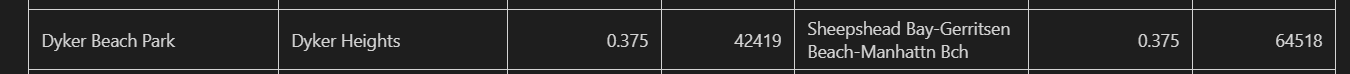

- Nogle har ikke et godt match.

- Nogle får også et match grundet "BlaBlaBlaBla-South" får en høj prefix confidence på "BlaBlaBlaBla-North"


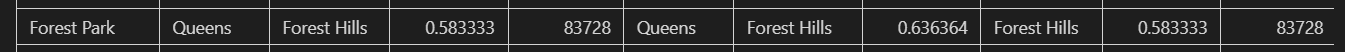

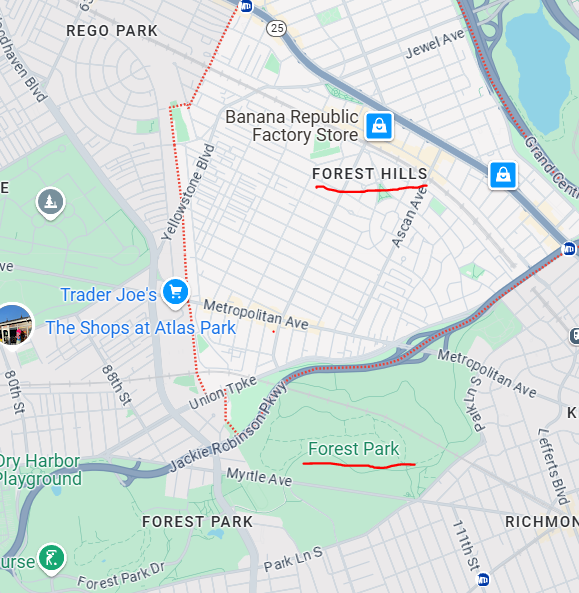

polygon data har parker. Man kan ikke bo i en park, bortset fra dem man godt kan bo i, så nogle mangler fra pop data. Så vi har fjernet dem som slutter på ordet "park" såsom Central park. Dog fjerner det også legit steder

# Merge NTA data based on common words

In [ ]:
# function to manually convert relevant NTA names to match
def manuel_nta_conversion(row):
    """
    Convert NTA names to match the format in the polygons data.
    """
    def convert_nta(nta):
        nta = nta.replace("Ft.", "Fort")

        # parks without population (use dots to make sure they dont match with any pop data. 
        # They should be assigned population 0)

        if "Lincoln Terrace Park" in nta:
            return "Lincoln.Terrace.Park"
        if "Rockaway Community Park" in nta :
            return "Rockaway.Community.Park"
        if "Van Cortlandt Park" in nta:
            return "Van.Cortlandt.Park"
        if "Flushing Meadows-Corona Park" in nta:
            return "Flushing.Meadows.Corona.Park" 
        if "Soundview Park" in nta:
            return "Soundview.Park"
        
        # From here: Merging polygons together and population data together so they match up

        if "Airport" in nta:
            return "Airport"
        if "Greenwich Village" in nta:
            return "West Village"
        # Van Nest-Morris Park-Westchester Square + Pelham Parkway-Van Nest
        if "Morris Park" in nta or "Westchester Square" in nta:
            return "Van Nest-Morris Park-Westchester Square"
        # Queensbridge-Ravenswood-Long Island City + Hunters Point-Sunnyside-West Maspeth
        if "Ravenswood" in nta:
            return "Ravenswood"
        if "Hunters Point" in nta or "Sunnyside" in nta:
            return "Hunters Point-Sunnyside"
        if "Fort Totten" in nta or "Bay Terrace" in nta:
            return "Bay Terrace-Clearview"
        if "Governors Island" in nta:
            return "Governors Island"
        if "Steinway" in nta:
            return "Steinway"
        if "Astoria" in nta:
            return "Old Astoria" if "Old" in nta else "Astoria"
        # pops data merged Allerton and pelham. Poly merged Pelham and Bronxdale
        if "Allerton" in nta or "Pelham Gardens" in nta or "Bronxdale" in nta:
            return "Allerton-Pelham Gardens"
        if "Battery Park City" in nta:
            return "Battery Park City"
        # Upper West Side-Lincoln Square
        if "Lincoln Square" in nta:
            return "Lincoln Square"
        if "Upper West Side" in nta:
            return "Upper West Side"
        # there is no polygon for Bedford. Seems merged with stuyvesant
        if "Stuyvesant" in nta:
            return "Stuyvesant Village" if "Village" in nta else "Bedford-Stuyvesant"
        if "Bedford" in nta:
            return "Bedford Park" if "Park" in nta else "Bedford-Stuyvesant"
        if "Bensonhurst" in nta:
            return "Bensonhurst"
        if "Bushwick" in nta:
            return "Bushwick"
        if "Claremont" in nta:
            return "Claremont"
        if "Manhattanville" in nta:
            return "Manhattanville"
        if "Harlem" in nta:
            if "East" in nta:
                return "East Harlem North" if "North" in nta else "East Harlem South"
            return "Central Harlem North" if "North" in nta else "Central Harlem South"
        if "Concourse" in nta:
            return "Concourse-Concourse Village"
        if "East New York" in nta:
            return "East New York"
        if "Erasmus" in nta:
            return "Erasmus"
        if "Remsen Village" in nta:
            return "Remsen Village"
        if "Flatbush" in nta:
            return "East Flatbush" if "East" in nta else "Flatbush"
        if "Murray Hill" in nta: 
            return "Murray Hill-Kips Bay" if "Kips Bay" in nta else "Murray Hill"
        if "Canarsie" in nta:
            return "Canarsie"
        if "Navy Yard" in nta:
            return "Navy Yard"
        if "Crotona Park" in nta:
            return "Crotona Park"
        if "Homecrest" in nta:
            return "Homecrest"
        if "Gravesend" in nta:
            return "Gravesend"
        if "Unionport" in nta:
            return "Unionport"
        # pop data merged these
        if "Castle Hill" in nta or "Clason Point" in nta or "Harding Park" in nta:
            return "Castle Hill-Clason Point-Harding Park"
        if "Dyker" in nta:
            return "Dyker Heights"
        if "Marine Park" in nta:
            return "Marine Park"
        if "Willets Point" in row["NTA Name"]:
            return "Flushing"
        if "Forest Park" in nta:
            return "Forest.Park"
        if "Fort Hamilton" in nta:	
            return "Bay Ridge"
        if "Great Kills" in nta or "Eltingville" in nta or "Annadale" in nta:
            return "AnnaDale-Great Kills-Eltingville"
        if "Highbridge" in nta:
            return "Highbridge"
        if "Cypress Hills" in nta:
            return "Cypress Hills"
        if "Inwood" in nta:
            return "Inwood"
        if "Breezy Point" in nta:
            return "Breezy Point"
        if "Kingsbridge" in nta:
            return "Kingsbridge Heights" if "Heights" in nta else "Kingsbridge"
        if "Midwood" in nta:
            return "Midwood"
        # Morrisania-Melrose
        if "Morrisania" in nta:
            return "Morrisania"
        if "Melrose" in nta:
            return "Melrose"
        if "Middle Village" in nta:
            return "Middle Village"
        if "Midtown" in nta:
            return "Midtown South" if "South" in nta else "East Midtown"
        if "Ozone Park" in nta:
            return "South Ozone Park" if "South" in nta else "Ozone Park"
        if "Prospect Park" in nta:
            return "Prospect.Park"
        if "Ravenswood" in nta:
            return "Queensbridge-Ravenswood"
        if "Pelham Bay" in nta:
            return "Pelham Bay"
        if "Civic Center" in nta or "Little Italy" in nta:
            return "SoHo-TriBeCa-Civic Center-Little Italy"
        if "Richmond Hill" in nta:
            return "Richmond Hill"
        if "Greenpoint" in nta:
            return "Greenpoint"
        # polygon data seems to have merged these two
        if "Williamsburg" in nta or "North Side-South Side" in nta: 
            return "Williamsburg"
        if "Woodside" in nta:
            return "Woodside"
        if "Sunset Park" in nta:
            return "Sunset Park West" if "West" in nta else "Sunset Park East"
        if "University Heights" in nta:
            return "University Heights"
        if "Woodlawn" in nta:
            return "Woodlawn"
        # two different names for the same place
        if "Hell's Kitchen" in nta:
            return "Clinton"
        # polygons and population cannot agree on how to split silver lake and St. George
        if "New Brighton" in nta:
            return "New Brighton"
        if "Brighton Beach" in nta:
            return "Brighton Beach"
        # polygons merged these two
        if "Coney Island" in nta or "West Brighton" in nta:
            return "Coney Island"
        
        return nta
    

    row["NTA Name"] = convert_nta(row["NTA Name"])

    return row

def identify_keywords(s, filter_common_words=False):
    """
    Split into words to find matches
    """
    # common words that doesn't help distinguish NTA's
    common_words = { 
                "park", "hill", "bay", "island", "harbor",
                "central", "south", "north", "east", "west",
                "mount", "beach", "point", "st.", "cemetery",
                "village", "center", "jamaica", "morris", "pelham",
                
    }
    # Remove special characters and convert to lowercase
    keys = set(re.sub(r"[^a-zA-Z0-9\'\.]", " ", s.lower()).split())
    if filter_common_words:
        keys = keys - common_words
    return keys

def find_candidates(row, df_to_scan, candidate_map, reverse_candidate_map):
    """
    If any word in a poly nta is in the pop nta, it is a candidate.
    """
    candidate_map[row["NTA Name"]] = set()
    keywords = identify_keywords(row["NTA Name"], filter_common_words=True)
    # check if any part is in any of the NTA names in other dataset
    for _, other_row in df_to_scan.iterrows():  
        other_keywords = identify_keywords(other_row["NTA Name"], filter_common_words=True)
        # if they have keywords in common or are have the same words exactly
        if len(keywords.intersection(other_keywords)) > 0 or identify_keywords(other_row["NTA Name"]) == identify_keywords(row["NTA Name"]):
            # add poly as candidate for pop
            candidate_map[row["NTA Name"]].add(other_row["NTA Name"])
            # register for the poly that this pop is pointing to it
            if reverse_candidate_map.get(other_row["NTA Name"]) is None:
                reverse_candidate_map[other_row["NTA Name"]] = set()
            reverse_candidate_map[other_row["NTA Name"]].add(row["NTA Name"])
    return row

def match_candidates(candidate_map):
    def candidate_score(nta, candidate) :
        """
        Score candidates based on the number of common keys, the number of keys not in common and the string distance
        """
        keys = identify_keywords(nta)
        candidate_keys = identify_keywords(candidate)
        common_keys = keys.intersection(candidate_keys)
        not_in_common_keys = keys.union(candidate_keys) - common_keys
        string_distance = abs(len(nta) - len(candidate))
        return (len(common_keys), -len(not_in_common_keys), -string_distance)

    matches = {}
    for nta, candidates in candidate_map.items():
        if not candidates:
            continue
        best_candidate = max(candidates, key=lambda c: candidate_score(nta, c))
        matches[nta] = best_candidate

    return matches

def apply_matching(row, matches) :
    """
    Rename pop Match names to match a polygon
    """
    # fx {"Allerton": "Allerton-Pelham Gardens"}
    # row["Match Name"] = "Allerton-Pelham Gardens"
    if row["NTA Name"] in matches:
        row["Match Name"] = matches[row["NTA Name"]]

    return row

def merge_poly_pop(poly_gdf_arg, pop_df_arg):
    """
    Merge the two dataframes. Goal is to have NTA's with population and polygons.
    """
    poly_gdf = poly_gdf_arg.copy()
    pop_df = pop_df_arg.copy()

    print("Number of polys initially", len(poly_gdf))
    print("Number of pop initially", len(pop_df))

    # manual renaming to catch some more
    poly_gdf = poly_gdf.apply(manuel_nta_conversion, axis=1)
    pop_df = pop_df.apply(manuel_nta_conversion, axis=1)

    # Some NTA's are grouped within the same df. 
    # Like Astoria (Central) and Astoria (East)-Woodside (North). Both are renamed to Astoria to merge them
    # disolve merges the polygons
    poly_gdf = poly_gdf.dissolve(by="NTA Name").reset_index()
    # Two pop nta's merged will sum the population
    pop_df = pop_df.groupby("NTA Name").agg({"Borough": "first", "Population": "sum"}).reset_index()

    print("Number of polys after grouping", len(poly_gdf))
    print("Number of pop after grouping", len(pop_df))
    
    # insert NTA_name and get candidate matches. Can be seen as a digraph where pop nodes point to poly nodes.
    candidate_map = {}
    # reverse is used to see how many in-going edges a poly has
    reverse_candidate_map = {}

    # go through each pop and find candidates in the pop df
    # it is a symmetric relation, and we cannot use populations without match, so we try to fit pops onto polys.
    # polys can be kept with a population of 0
    pop_df.apply(find_candidates, axis=1, args=(poly_gdf, candidate_map, reverse_candidate_map))

    # These polys where not candidates for any pops. Keys are only added when something points to poly
    polys_without_candidates = set(poly_gdf["NTA Name"]) - reverse_candidate_map.keys()
    print("Polys without candidates", len(polys_without_candidates))

    # all pops have a key, filter to only get those with a nonempty set
    pops_without_candidates = set(pop_df["NTA Name"]) - set(filter(lambda key: len(candidate_map.get(key)) > 0, candidate_map.keys()))
    print("Pops without candidates", len(pops_without_candidates))
    print(pops_without_candidates)

    # add match name columns. They will be merged based on this column
    poly_gdf["Match Name"] = poly_gdf["NTA Name"]
    pop_df["Match Name"] = pop_df["NTA Name"]

    matches = match_candidates(candidate_map)

    print("Non-equal matches", dict(filter(lambda entry: entry[0] != entry[1], matches.items())))

    print("Number of matches", len(matches))

    # if two NTA's match their Match Name should be the same. We rename pops to match the polygons.
    pop_df = pop_df.apply(apply_matching, axis=1, args=(matches,))
    
    pop_df = pop_df.groupby("Match Name").agg({"Borough": "first", "Population": "sum", "NTA Name": "first"}).reset_index()

    # join on NTA Name and Borough to create the desired table. Keep NTA names as poly_NTA and pop_NTA
    merged_gdf = poly_gdf.merge(pop_df, how="left", left_on=["Match Name", "Borough"], right_on=["Match Name", "Borough"], suffixes=("_poly", "_pop"))

    # polys without candidates get population 0
    def set_0_populations(row) :
        if row["NTA Name_poly"] in polys_without_candidates :
            row["Population"] = 0
        return row

    merged_gdf = merged_gdf.apply(set_0_populations, axis=1)

    polys_with_pop = merged_gdf[~merged_gdf["Population"].isna()]
    print("NTA's with population", len(polys_with_pop))

    print("NTA's with population 0:", len(merged_gdf[merged_gdf["Population"] == 0]))
    print(list(merged_gdf[merged_gdf["Population"] == 0]["NTA Name_poly"]))

    polys_with_missing_pop = merged_gdf[merged_gdf["Population"].isna()]
    print("NTA's with missing population:", len(polys_with_missing_pop))
    print(polys_with_missing_pop[["Borough", "NTA Name_poly"]])

    # unmerged NTA's
    unmerged_pops = pop_df[~pop_df["NTA Name"].isin(merged_gdf["NTA Name_pop"])]
    print("Unmerged pops:", len(unmerged_pops))
    print(unmerged_pops[["Borough", "NTA Name", "Match Name"]])

    return merged_gdf

# only keep 2010 to remove duplicates
nta_pop_simple_df = nta_pop_df[nta_pop_df["Year"] == 2010]

# rename columns to match
nta_poly_simple_gdf = nta_polys_gdf.rename(columns={"NTAName": "NTA Name", "BoroName": "Borough"})

# convert to geodataframe
nta_poly_simple_gdf = gpd.GeoDataFrame(nta_poly_simple_gdf, geometry=nta_poly_simple_gdf["the_geom"].apply(loads), crs=CRS_LOAD).to_crs(CRS_METERS)

# perform merge
merged_gdf = merge_poly_pop(nta_poly_simple_gdf, nta_pop_simple_df)
merged_gdf = merged_gdf.rename(columns={"NTA Name_poly" : "NTA Name"})
# Only keep relevant columns (NTA2020 acs as unique id)
merged_gdf = merged_gdf[["NTA2020", "NTA Name", "Borough", "geometry", "Population"]]

# plot polygons colored by population
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
merged_gdf.plot(column="Population", ax=ax, legend=True, cmap="viridis", edgecolor="black")
ax.set_axis_off()
plt.show()

print("Result")
merged_gdf.head(3)

## Amenities data

In [ ]:
amenities_data_path = "./data/NYC_Amenities.csv"

# Function to extract coordinates from Point objects or calculate centroid for Polygons
def extract_coordinates(geometry):
    if isinstance(geometry, Point):
        return geometry.x, geometry.y
    elif isinstance(geometry, Polygon):
        centroid = geometry.centroid
        return centroid.x, centroid.y
    return None, None

amenities_df = None
amenities_gdf = None

# Apply the function to the dataset
if os.path.exists(amenities_data_path):
    print("Loading amenities data from local file...")
    amenities_df = pd.read_csv(amenities_data_path, low_memory=False)
    # convert to geodataframe
    amenities_gdf = gpd.GeoDataFrame(
        amenities_df,
        geometry=amenities_df["geometry"].apply(loads).apply(lambda x: x.centroid), # we simplify
        crs=CRS_LOAD,
    ).to_crs(CRS_METERS)
else:
    print("Querying OSM for amenities data...")
    # Define a dictionary of tags for the amenities you're interested in
    tags = {
        "amenity": ["bar", "restaurant"],
        "leisure": "park",
        "railway": "station"
    }

    # Use OSMnx to query OSM for these features in New York City
    amenities_gdf = ox.features.features_from_place("New York City, USA", tags)

    # Extract coordinates or calculate centroid
    amenities_gdf[['Longitude', 'Latitude']] = amenities_gdf['geometry'].apply(lambda x: pd.Series(extract_coordinates(x)))

    # Save the queried data to a CSV file for future use
    amenities_gdf.to_csv(amenities_data_path, index=False)
    amenities_df = amenities_gdf

# Create a new column 'category' to combine 'leisure' and 'amenity'
amenities_gdf['category'] = amenities_gdf['leisure'].combine_first(amenities_gdf['amenity']).combine_first(amenities_gdf['railway'])

# 5) Filter to exactly the four types you want
keep = ["bar", "restaurant", "park", "station"]
amenities_gdf = amenities_gdf[amenities_gdf["category"].isin(keep)]

# Only keep relevant columns
amenities_gdf = amenities_gdf[["category", "Latitude", "Longitude", "geometry"]]

for amenity in amenities_gdf['category'].unique():
    print(f"Number of {amenity}: {len(amenities_gdf[amenities_gdf['category'] == amenity])}")
    
amenities_gdf.head(3)

# HVAD ER DET RENT FAKTISK VI ØNSKER


|| = column name in NTA polygon table
|columnName|

Everything with population is per 1000 citizens.


Formula: "X Crime per population":
* Violation per population |violation_per_capita|
* Misdemeanor per population |misdemeanor_per_capita|
* Felony per population |felony_per_capita|

Formula: "X amenities per population"
* "Bars per population" |bar_per_capita|
* "parks per population" |park_per_capita|
* "restaurants per population" |restaurant_per_capita|
* "stations per population" |station_per_capita|

Formula: "Crime-to-amenity Ratio"
* Overall crime per bar |crime_per_bar|
* Overall crime per parks |crime_per_park|
* Overall crime per restaurants |crime_per_restaurant|
* Overall crime per stations |crime_per_station|
* 
* Violation per bar |violation_per_bar|
* Violation per parks |violation_per_park|
* Violation per restaurants |violation_per_restaurant|
* Violation per stations |violation_per_station|
* 
* Misdemeanor per bar |misdemeanor_per_bar|
* Misdemeanor per parks |misdemeanor_per_park|
* Misdemeanor per restaurants |misdemeanor_per_restaurant|
* Misdemeanor per stations |misdemeanor_per_station|
* 
* Felony per bar |felony_per_bar|
* Felony per parks |felony_per_park|
* Felony per restaurants |felony_per_restaurant|
* Felony per stations |felony_per_station|

## Hvorfor ikke density?? (Altså bruge NTA polygon AREA)

Fordi i New York ville det pretty much altid endnu ud i en "høj-hus spotter". Da de har en mega kompakt density af alt, både crime, population og amenities.


In [ ]:
# === Count crimes by NTA and category ===
crime_ntas = gpd.sjoin(
    crime_gdf[['LAW_CAT_CD', 'geometry']],
    merged_gdf[['NTA2020', 'geometry']], # NTA2020 acts as unique id
    how='inner', # crime points within NTA polygons
    predicate='within'
)

crime_counts = (
    crime_ntas
    .groupby(['NTA2020', 'LAW_CAT_CD'])
    .size() # number of crimes per polygon
    .unstack(fill_value=0)
)


# ensure all three categories exist
for cat in ['VIOLATION','MISDEMEANOR','FELONY']:
    if cat not in crime_counts.columns:
        crime_counts[cat] = 0

crime_counts = crime_counts[['VIOLATION','MISDEMEANOR','FELONY']]
crime_counts.columns = ['Violation','Misdemeanor','Felony']
print(crime_counts.head(3))


# === Count amenities by NTA and type ===

amen_ntas = gpd.sjoin(
    amenities_gdf[['category', 'geometry']],
    merged_gdf[['NTA2020','geometry']],
    how='inner',
    predicate='within'
)
amen_counts = (
    amen_ntas
    .groupby(['NTA2020', 'category'])
    .size()
    .unstack(fill_value=0)
)

# ensure all four types exist
for a in ['bar','park','restaurant','station']:
    if a not in amen_counts.columns:
        amen_counts[a] = 0

# === Join counts back to NTA GeoDataFrame ===
nta_gdf = merged_gdf.set_index('NTA2020').copy()
nta_gdf = nta_gdf.join(crime_counts).join(amen_counts).fillna(0).reset_index()

# === Compute metrics ===
nta_gdf['total_crime'] = nta_gdf[['Violation','Misdemeanor','Felony']].sum(axis=1)

# population density. People per square kilometer
nta_gdf['population_density'] = nta_gdf['Population'] / nta_gdf.geometry.area * 1000 * 1000

# per capita metrics. x per 100k people
for col in ['Violation', 'Misdemeanor', 'Felony', 'bar', 'park', 'restaurant', 'station', 'total_crime']:
    col_name = col.replace('total_crime', 'crime').lower()
    nta_gdf[f"{col_name}_per_capita"] = nta_gdf[col] / nta_gdf['Population'] * 100_000

# === crime type per amenity type ===
for ct in ['Violation','Misdemeanor','Felony', 'total_crime']:
    ct_name = ct.replace('total_crime', 'crime').lower()
    for a in ['bar','park','restaurant','station']:
        nta_gdf[f"{ct_name}_per_{a}"] = nta_gdf[ct] / nta_gdf[a]

nta_gdf.replace([np.inf, -np.inf], np.nan, inplace=True)

nta_gdf[nta_gdf['population_density'] > 0].plot(column='population_density', kind='hist', bins=30, title='Population Density Distribution (excluding 0 values)')

# === Display 5-row sample (no geometry/the_geom) ===
nta_gdf[nta_gdf['Population'] > 0].head(5).drop(columns=['geometry'])

# VISUALIZATION

## Interactive map

In [ ]:
# huge thanks to gpt for this one

# === CONFIGURATION ===
USE_SAMPLE      = True
SAMPLE_FRACTION = 0.03
RANDOM_STATE    = 42

crime     = crime_gdf.to_crs(CRS_LOAD)
amenities = amenities_gdf.to_crs(CRS_LOAD)
ntas_map  = nta_gdf.to_crs(CRS_LOAD)

if USE_SAMPLE:
    crime = crime.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_STATE)

crime['lat'], crime['lon'] = crime.geometry.y, crime.geometry.x
amen_centroids             = amenities.geometry.centroid
amenities['lat'], amenities['lon'] = amen_centroids.y, amen_centroids.x

# === INITIALIZE MAP ===
center = [crime['lat'].mean(), crime['lon'].mean()]
m = folium.Map(location=center, zoom_start=11, tiles=None, name="map")
folium.TileLayer('CartoDB Positron', name='Basemap', control=False).add_to(m)

# === 1) Crime Points & Clusters ===
crime_point_layers   = []
crime_cluster_layers = []

for category, color in [('Felony','crimson'),('Misdemeanor','orange'),('Violation','blue')]:
    fg_pts = folium.FeatureGroup(name=category, show=False)
    for _, r in crime[crime['LAW_CAT_CD'].str.title()==category].iterrows():
        folium.CircleMarker([r.lat, r.lon], radius=3,
                            color=color, fill=True, fill_opacity=0.6
                           ).add_to(fg_pts)
    fg_pts.add_to(m)
    crime_point_layers.append(fg_pts)

    fg_cl = MarkerCluster(name=category, show=False)
    for _, r in crime[crime['LAW_CAT_CD'].str.title()==category].iterrows():
        folium.Marker([r.lat, r.lon]).add_to(fg_cl)
    fg_cl.add_to(m)
    crime_cluster_layers.append(fg_cl)

# === 2) Amenity Points & Clusters ===
amenity_point_layers   = []
amenity_cluster_layers = []

for amen, color in [('Bar','purple'),
                    ('Restaurant','darkgreen'),
                    ('Park','green'),
                    ('Station','cadetblue')]:
    fg_pts = folium.FeatureGroup(name=amen, show=False)
    mc     = MarkerCluster().add_to(fg_pts)
    subset = amenities[amenities['category'].str.title()==amen]
    for _, r in subset.iterrows():
        folium.CircleMarker([r.lat, r.lon], radius=3,
                            color=color, fill=True, fill_opacity=0.6
                           ).add_to(mc)
    fg_pts.add_to(m)
    amenity_point_layers.append(fg_pts)

    fg_cl = MarkerCluster(name=amen, show=False)
    for _, r in subset.iterrows():
        folium.Marker([r.lat, r.lon]).add_to(fg_cl)
    fg_cl.add_to(m)
    amenity_cluster_layers.append(fg_cl)

# === 3) Heatmaps ===
heatmaps = []

# crime heat
fg = folium.FeatureGroup(name="Crime Heatmap", show=False)
HeatMap(list(zip(crime.lat, crime.lon)),
        radius=15, blur=10, min_opacity=0.3).add_to(fg)
fg.add_to(m); heatmaps.append(fg)

# all-amenities
fg = folium.FeatureGroup(name="Amenity Heatmap (All)", show=False)
HeatMap(list(zip(amenities.lat, amenities.lon)),
        radius=15, blur=10, min_opacity=0.3).add_to(fg)
fg.add_to(m); heatmaps.append(fg)

# per-category heatmaps
for amen in ['bar','restaurant','park','station']:
    name = f"Amenity Heatmap ({amen.title()})"
    fg   = folium.FeatureGroup(name=name, show=False)
    pts  = amenities[amenities['category']==amen]
    HeatMap(list(zip(pts.lat, pts.lon)),
            radius=15, blur=10, min_opacity=0.3).add_to(fg)
    fg.add_to(m); heatmaps.append(fg)

# === 4) Choropleth Style Helper ===
def get_cuts(series, bins):
    # quantiles
    return list(series.quantile(np.linspace(0,1,bins)).values)
    # equal intervals
    #return np.linspace(series.min(), series.max(), bins)
    # standard deviations (assume odd number of bins)
    #return list(series.mean() + series.std() * np.arange(-bins//2, bins//2+1)) # don't use. right skewed data

def make_style(field, colors, cuts):
    def style_fn(feat):
        v = feat['properties'].get(field)
        if v is None or np.isnan(v):
            c = 'lightgray'
        else:
            for i, thr in enumerate(cuts[1:]):
                if v <= thr:
                    c = colors[i]
                    break
            else:
                c = colors[-1]
        return {'fillColor': c, 'color':'black', 'weight':1, 'fillOpacity':0.7}
    return style_fn

# === 5) Define All Choropleths & Legends ===
choropleth_layers = []
choropleths = [
    # field                  | Layer Name               | Legend ID      | Title                | Color Ramp
    ('Population',            'Population',              'leg-pop',       'Population',          ['#edf8fb','#b2e2e2','#66c2a4','#2ca25f','#006d2c']),
    ('population_density',    'Population Density',      'leg-popden',    'Population Density',  ['#f7fcfd','#ccece6','#66c2a4','#238b45','#00441b']),
    ('crime_per_capita',      'Crime per Capita',        'leg-crpc',      'Crime per Capita',    ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#de2d26']),
    ('violation_per_capita',  'Violation per Capita',    'leg-vipc',      'Violation per Capita',['#ffffe5','#fff7bc','#fee391','#fec44f','#d95f0e']),
    ('misdemeanor_per_capita','Misdemeanor per Capita',  'leg-mipc',      'Misdemeanor per Capita',['#f7fbff','#deebf7','#9ecae1','#3182bd','#08519c']),
    ('felony_per_capita',     'Felony per Capita',       'leg-fepc',      'Felony per Capita',   ['#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6']),

    ('bar_per_capita',        'Bars per Capita',         'leg-barpc',     'Bars per Capita',     ['#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6']),
    ('park_per_capita',       'Parks per Capita',        'leg-parkpc',    'Parks per Capita',    ['#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b','#31a354']),
    ('restaurant_per_capita', 'Restaurants per Capita',  'leg-restpc',    'Restaurants per Capita',['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#e6550d']),
    ('station_per_capita',    'Stations per Capita',     'leg-stapc',     'Stations per Capita', ['#f7fcf0','#e0f3db','#ccebc5','#a8ddb5','#43a2ca']),

    ('crime_per_bar',         'Crime per Bar',           'leg-cpb',       'Crime per Bar',        ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#de2d26']),
    ('crime_per_park',        'Crime per Park',          'leg-cpp',       'Crime per Park',       ['#f7fbff','#deebf7','#9ecae1','#3182bd','#08519c']),
    ('crime_per_restaurant',  'Crime per Restaurant',    'leg-cpr',       'Crime per Restaurant', ['#ffffe5','#fff7bc','#fee391','#fec44f','#d95f0e']),
    ('crime_per_station',     'Crime per Station',       'leg-cps',       'Crime per Station',    ['#f7fcfd','#ccece6','#66c2a4','#238b45','#00441b']),

    ('violation_per_bar',       'Violations per Bar',        'leg-vpb',       'Violations per Bar',       ['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#67a9cf']),
    ('violation_per_park',      'Violations per Park',       'leg-vpp',       'Violations per Park',      ['#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b','#31a354']),
    ('violation_per_restaurant','Violations per Restaurant',  'leg-vpr',       'Violations per Restaurant',['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#e6550d']),
    ('violation_per_station',   'Violations per Station',    'leg-vps',       'Violations per Station',   ['#f7fcf0','#e0f3db','#ccebc5','#a8ddb5','#43a2ca']),

    ('misdemeanor_per_bar',       'Misdemeanors per Bar',        'leg-mpb',       'Misdemeanors per Bar',       ['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#67a9cf']),
    ('misdemeanor_per_park',      'Misdemeanors per Park',       'leg-mpp',       'Misdemeanors per Park',      ['#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b','#31a354']),
    ('misdemeanor_per_restaurant','Misdemeanors per Restaurant',  'leg-mpr',       'Misdemeanors per Restaurant',['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#e6550d']),
    ('misdemeanor_per_station',   'Misdemeanors per Station',    'leg-mps',       'Misdemeanors per Station',   ['#f7fcf0','#e0f3db','#ccebc5','#a8ddb5','#43a2ca']),

    ('felony_per_bar',       'Felonies per Bar',        'leg-fpb',       'Felonies per Bar',        ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#de2d26']),
    ('felony_per_park',      'Felonies per Park',       'leg-fpp',       'Felonies per Park',       ['#f7fbff','#deebf7','#9ecae1','#3182bd','#08519c']),
    ('felony_per_restaurant','Felonies per Restaurant', 'leg-fpr',       'Felonies per Restaurant', ['#ffffe5','#fff7bc','#fee391','#fec44f','#d95f0e']),
    ('felony_per_station',   'Felonies per Station',    'leg-fps',       'Felonies per Station',    ['#f7fcfd','#ccece6','#66c2a4','#238b45','#00441b']),
]

for field, _, lid, title, colors in choropleths:
    series = ntas_map[field]
    cuts   = get_cuts(series, bins=len(colors)+1)

    # 1) Create the GeoJson layer itself (no FeatureGroup wrapper)
    gj = folium.GeoJson(
        ntas_map,
        name=title,
        show=False,
        style_function=make_style(field, colors, cuts),
        highlight_function=lambda feat: {
            'weight': 2, 'color': 'black', 'fillOpacity': 0.9
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['NTA Name', field],
            aliases=['Neighborhood', title],
            localize=True
        )
    ).add_to(m)

    # 2) Keep track of it so LayerControl can toggle it
    choropleth_layers.append(gj)

    

# === 6) Grouped Layer Control & Render ===
GroupedLayerControl(
    groups={
      'Crime Points':         crime_point_layers,
      'Crime Clusters':       crime_cluster_layers,
      'Amenity Points':       amenity_point_layers,
      'Amenity Clusters':     amenity_cluster_layers,
      'Heatmaps':             heatmaps,
      'NTA Choropleths':      choropleth_layers
    },
    collapse=False,
    position='topright',
    exclusive_groups=False, # makes checkboxes instead of radio buttons
).add_to(m)

# === Display ===
m

# The Three methods

In [ ]:
try:
    from IPython.display import display, Markdown
except ImportError:
    def display(x): print(str(x))
    def Markdown(x): print(str(x))

# === Setup ===
amenity_types = ['Bar', 'Park', 'Station', 'Restaurant'] # Used for Moran's I context
crime_types = ['Felony', 'Misdemeanor', 'Violation']
MAX_POINTS_FOR_K_ANALYSIS = 5000  # Threshold for sampling points for Ripley's K

# === Result Storage ===
ripley_results = []
hopkins_results = []
moran_results = []

# === Interpretation Helper Functions ===
def get_ripley_interpretation_hint(max_diff):
    if pd.isna(max_diff):
        return "N/A"
    # Thresholds are illustrative; in practice, significance envelopes are used.
    if max_diff > 1000:  # Arbitrary threshold for "stronger" deviation
        return "Pattern Deviates (Suggests Clustering)"
    elif max_diff < -1000: # Arbitrary threshold
        return "Pattern Deviates (Suggests Dispersion)"
    elif -100 <= max_diff <= 100: # Arbitrary threshold for "close to random"
        return "Pattern Appears Consistent with Randomness"
    elif max_diff > 0:
        return "Suggests Clustering Tendency"
    else: # max_diff < 0
        return "Suggests Dispersion/Regularity Tendency"

def get_hopkins_interpretation_hint(h_value):
    if pd.isna(h_value):
        return "N/A"
    if h_value > 0.75: return "Strongly Clustered"
    if h_value > 0.65: return "Moderately Clustered"
    if h_value > 0.55: return "Weakly Clustered"
    if h_value >= 0.45: return "Likely Random"
    if h_value < 0.35: return "Suggests Strong Regularity/Dispersion"
    return "Suggests Regularity/Dispersion"

def get_moran_interpretation_hint(i_value, p_value):
    if pd.isna(i_value) or pd.isna(p_value):
        return "N/A"
    if p_value < 0.05:
        if i_value > 0.1: # Threshold for I can vary based on context
            return "Significant Positive Autocorrelation (Clustering of Similar Values)"
        elif i_value < -0.1:
            return "Significant Negative Autocorrelation (Clustering of Dissimilar Values)"
        else:
            return "Significant, but Weak Autocorrelation"
    return "No Significant Autocorrelation (Pattern may be Random)"

# === Analysis Functions ===

def run_all_k(crime_gdf):
    global ripley_results
    for crime_type in crime_types:
        
        crime_df_filtered = crime_gdf[crime_gdf['LAW_CAT_CD'] == crime_type]
        max_diff_val, status_val = None, 'OK'

        
        crime_df = crime_df_filtered.to_crs(epsg=CRS_METERS)
        crime_df = crime_df[crime_df.geometry.geom_type == 'Point']
        
        coords_full = np.array(list(zip(crime_df.geometry.x, crime_df.geometry.y)))
        
        # --- ADDED SAMPLING LOGIC ---
        coords = coords_full
        num_original_points = len(coords_full)
        if num_original_points > MAX_POINTS_FOR_K_ANALYSIS:
            print(f"Info for {crime_type}: Point count ({num_original_points}) > {MAX_POINTS_FOR_K_ANALYSIS}. Sampling for Ripley's K.")
            sample_indices = np.random.choice(num_original_points, MAX_POINTS_FOR_K_ANALYSIS, replace=False)
            coords = coords_full[sample_indices]
            status_val = f'OK (Sampled to {MAX_POINTS_FOR_K_ANALYSIS} from {num_original_points} pts)'
        # --- END SAMPLING LOGIC ---

        bbox = crime_df.total_bounds # Bbox of original filtered data for study area context
        
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        
        max_d_heuristic_components = []
        if width > 0: max_d_heuristic_components.append(width / 4)
        if height > 0: max_d_heuristic_components.append(height / 4)
        
        if not max_d_heuristic_components: 
            max_d_heuristic = 3000 
        else:
            max_d_heuristic = min(max_d_heuristic_components)
            
        max_d = min(3000, max_d_heuristic)
        
        
        start_d = max(1.0, max_d / 30) 
        d_values_support = np.linspace(start_d, max_d, 30)
        
        try:
            actual_support, k_obs = k(coords, support=d_values_support, edge_correction=None)
            
            k_theo = np.pi * actual_support**2 
            
            if np.all(np.isnan(k_obs)):
                raise ValueError("pointpats.k calculation resulted in all NaNs.")
            
            diff = k_obs - k_theo
            
            if np.any(~np.isnan(diff)):
                max_diff_val = np.nanmax(diff)
            else: 
                max_diff_val = None
            
        except MemoryError as me:
            status_val = f'k-Func MemoryError (pointpats): {str(me)[:100]}. Try lowering MAX_POINTS_FOR_K_ANALYSIS.'
        except Exception as e:
            status_val = f'k-Func Error (pointpats): {str(e)[:100]}'
        
        ripley_results.append({
            'Crime Type': crime_type, 'Status': status_val,
            'Max K(d) - E[K(d)]': max_diff_val,
            'Interpretation Hint': get_ripley_interpretation_hint(max_diff_val)
        })

def hopkins_statistic(points, n_samples=None):
    n_points = len(points)
    if n_samples is None: n_samples = min(100, max(10, int(n_points/5))) 
    if n_samples <= 0 or n_samples > n_points : return None 

    xmin, ymin = points.min(axis=0)
    xmax, ymax = points.max(axis=0)
    
    if xmax == xmin or ymax == ymin: return None 
    
    random_points = np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=(n_samples, 2))
    
    if n_points < 2: return None

    nn_rand_to_actual = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points)
    u_distances, _ = nn_rand_to_actual.kneighbors(random_points)
    u_distances = u_distances.flatten()
    
    sample_indices = np.random.choice(n_points, n_samples, replace=False)
    w_distances = []
    for idx in sample_indices:
        current_point = points[idx].reshape(1, -1)
        mask = np.ones(n_points, dtype=bool)
        mask[idx] = False 
        other_points = points[mask]
        
        if len(other_points) == 0: continue

        nn_actual_to_other_actual = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(other_points)
        dist, _ = nn_actual_to_other_actual.kneighbors(current_point)
        w_distances.append(dist[0][0])
        
    w_distances = np.array(w_distances)
    
    u_distances = u_distances[np.isfinite(u_distances)]
    w_distances = w_distances[np.isfinite(w_distances)]
    
    if len(u_distances) == 0 or len(w_distances) == 0: return None 
    
    sum_u = np.sum(u_distances)
    sum_w = np.sum(w_distances)
    
    if (sum_u + sum_w) == 0: 
        return 0.5 
        
    return sum_u / (sum_u + sum_w)


def run_all_hopkins(crime_gdf): # Hopkins is usually less memory intensive but good to be mindful
    global hopkins_results
    # Consider sampling for Hopkins if crime_gdf is extremely large, though typically less critical than K-func
    # MAX_POINTS_FOR_HOPKINS = 10000 # Example threshold
    for crime_type in crime_types:
        if 'LAW_CAT_CD' not in crime_gdf.columns:
            hopkins_results.append({
                'Crime Type': crime_type, 'Hopkins H': None, 'Status': "Missing 'LAW_CAT_CD' in crime_gdf",
                'Interpretation Hint': get_hopkins_interpretation_hint(None)
            })
            continue
        
        crime_proj_filtered = crime_gdf[crime_gdf['LAW_CAT_CD'].str.title() == crime_type]
        h_val, status_val = None, 'OK'

        if crime_proj_filtered.empty: status_val = 'No Crime Data';
        else:
            crime_proj_df = crime_proj_filtered.to_crs(epsg=CRS_METERS)
            crime_proj_df = crime_proj_df[crime_proj_df.geometry.geom_type == 'Point']
            
            # Optional: Add sampling for Hopkins if needed
            # num_original_hopkins = len(crime_proj_df)
            # if num_original_hopkins > MAX_POINTS_FOR_HOPKINS:
            #     print(f"Info for {crime_type}: Sampling {MAX_POINTS_FOR_HOPKINS} from {num_original_hopkins} for Hopkins.")
            #     crime_proj_df = crime_proj_df.sample(MAX_POINTS_FOR_HOPKINS)
            #     status_val += f' (Sampled to {MAX_POINTS_FOR_HOPKINS})'

            if len(crime_proj_df) < 20: status_val = 'Insufficient Crime Data (<20 pts)'; # Using 20 as a general threshold
            else:
                crime_coords = np.array(list(zip(crime_proj_df.geometry.x, crime_proj_df.geometry.y)))
                if crime_coords.shape[0] < 2 or crime_coords.ndim != 2 or crime_coords.shape[1] != 2: status_val = 'Invalid Crime Coords';
                else:
                    try:
                        h_val = hopkins_statistic(crime_coords)
                        if h_val is None: status_val = 'Calc Error/Unsuitable Data'
                    except MemoryError as me:
                        status_val = f'Hopkins MemoryError: {str(me)[:50]}'
                    except Exception as e: status_val = f'Hopkins Error: {str(e)[:50]}'
        hopkins_results.append({
            'Crime Type': crime_type, 'Hopkins H': h_val, 'Status': status_val,
            'Interpretation Hint': get_hopkins_interpretation_hint(h_val)
        })

def run_all_morans(ntas_map_input):
    global moran_results
    ntas_df = ntas_map_input.copy() 
    if 'geometry' not in ntas_df.columns or not hasattr(ntas_df, 'geometry'):
        for ct in crime_types:
            for at in amenity_types:
                moran_results.append({'Crime Type': ct, 'Amenity Type (Context for Ratio)': at, 'Moran\'s I (Global)': None, 'p-value': None, 'Status': 'Invalid NTA map (no geometry)', 'Interpretation Hint': 'N/A'})
        return

    original_index_name = ntas_df.index.name 
    if not ntas_df.index.is_unique:
        if original_index_name: 
             try:
                ntas_df = ntas_df.reset_index() 
             except Exception: 
                ntas_df = ntas_df.reset_index(drop=True)
        else:
            ntas_df = ntas_df.reset_index(drop=True)
    
    for crime_type in crime_types:
        for amenity_type in amenity_types: 
            field = f"{crime_type.lower()}_per_{amenity_type.lower()}"
            i_val, p_val, status_val = None, None, 'OK'
            series_data = ntas_df[field].fillna(0)
            
            ntas_df_valid_geom = ntas_df[ntas_df.geometry.is_valid & ~ntas_df.geometry.is_empty & ntas_df.geometry.notna()].copy() 
            
            series_data_valid = series_data.loc[ntas_df_valid_geom.index]

            if ntas_df_valid_geom.index.is_unique:
                current_ids = ntas_df_valid_geom.index.tolist()
                w = libpysal.weights.Queen.from_dataframe(ntas_df_valid_geom, ids=current_ids, use_index=True) 
            else:
                ntas_df_valid_geom_reset = ntas_df_valid_geom.reset_index(drop=True)
                series_data_valid = series_data_valid.iloc[ntas_df_valid_geom_reset.index] 
                current_ids = ntas_df_valid_geom_reset.index.tolist() 
                w = libpysal.weights.Queen.from_dataframe(ntas_df_valid_geom_reset, ids=current_ids, use_index=True)

            w.transform = 'r'

            if w.n == 0 or not w.neighbors or len(w.neighbors) == 0 : raise ValueError("W matrix empty/no neighbors.")
            
            mi = esda.Moran(series_data_valid.values, w, permutations=999) 
            i_val, p_val = mi.I, mi.p_sim
            moran_results.append({
                'Crime Type': crime_type, 'Amenity Type (Context for Ratio)': amenity_type,
                'Moran\'s I (Global)': i_val, 'p-value': p_val, 'Status': status_val,
                'Interpretation Hint': get_moran_interpretation_hint(i_val, p_val)
            })


# === Display Results (Enhanced for GDS Exam) ===
def show_results():
    global ripley_results, hopkins_results, moran_results

    ripley_df = pd.DataFrame(ripley_results)
    hopkins_df = pd.DataFrame(hopkins_results)
    moran_df = pd.DataFrame(moran_results)

    table_styles = [
        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold'), ('background-color', '#e0e0e0'), ('padding', '8px'), ('border', '1px solid #c0c0c0')]},
        {'selector': 'td', 'props': [('text-align', 'left'), ('padding', '8px'), ('border', '1px solid #dcdcdc')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f7f7f7')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#efefff')]}, 
        {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%'), ('margin-top', '15px'), ('margin-bottom', '15px'), ('font-family', 'Arial, sans-serif'), ('font-size', '0.9em'), ('box-shadow', '0 2px 5px rgba(0,0,0,0.1)')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '1.1em'), ('font-weight', 'bold'), ('margin-bottom', '10px'), ('text-align', 'left'), ('color', '#333')]}
    ]
    
    display(Markdown("<h1 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;'>Geospatial Data Science Analysis Results</h1>"))

    display(Markdown("<h2 style='color: #2980b9;'>1. Ripley's K-function: Point Pattern Analysis</h2>"))
    styled_ripley = ripley_df.style.format({'Max K(d) - E[K(d)]': "{:,.2f}"}, na_rep="[Value]") \
                                    .set_table_styles(table_styles) \
                                    .set_caption("Summary of Ripley's K-function Analysis")
    try: 
        styled_ripley = styled_ripley.hide(axis="index")
    except AttributeError: 
        styled_ripley = styled_ripley.hide_index()

    styled_ripley = styled_ripley.set_properties(**{'width': '150px'}, subset=['Interpretation Hint']) 
    display(styled_ripley)
    
    display(Markdown("""
<div style="margin-top: 10px; margin-bottom: 25px; padding: 12px; background-color: #f8f9fa; border-left: 5px solid #17a2b8; font-size: 0.9em;">
    <strong>Understanding Ripley's K-function:</strong>
    <ul>
        <li>Ripley's K-function (K(d)) evaluates spatial clustering or dispersion of points over a range of distances (d).</li>
        <li>It compares the observed K(d) to what's expected under Complete Spatial Randomness (CSR). For CSR, the expected K(d) is E[K(d)] = πd². This implementation uses <code>pointpats.distance_statistics.k</code> to get observed K(d).</li>
        <li><b>Note:</b> The basic <code>pointpats.distance_statistics.k</code> function may not implement edge correction or may have limitations with very large datasets. For analyses requiring robust edge correction or handling large N, consider using higher-level estimator classes (e.g., <code>pointpats.distance_statistics.K</code> which is <code>RipleyKEstimator</code>) or test functions (e.g., <code>k_test</code>) with appropriate parameters and sampling if necessary. Results without edge correction can be less reliable.</li>
        <li><b>K(d) - E[K(d)] > 0:</b> Suggests clustering at distance d.</li>
        <li><b>K(d) - E[K(d)] < 0:</b> Suggests dispersion or regular spacing at distance d.</li>
        <li>The table shows the <em>maximum difference</em>. For rigorous analysis, significance testing using simulation envelopes is highly recommended.</li>
    </ul>
</div>""")) 

    display(Markdown("<h2 style='color: #2980b9;'>2. Hopkins Statistic: Test for Spatial Randomness</h2>"))
    
    def hopkins_cell_styler(val):
        style = ''
        if pd.notnull(val) and isinstance(val, (float, int)):
            if val > 0.75: style = 'color: darkgreen; font-weight: bold;'
            elif val > 0.65: style = 'color: green;'
            elif val > 0.55: style = 'color: darkgoldenrod;'
            elif val >= 0.45: style = 'color: #555;' 
            else: style = 'color: darkred; font-weight: bold;'
        return style
    
    df_style_hopkins = pd.DataFrame('', index=hopkins_df.index, columns=hopkins_df.columns)
    if 'Hopkins H' in hopkins_df.columns:
        df_style_hopkins['Hopkins H'] = hopkins_df['Hopkins H'].apply(hopkins_cell_styler)

    styled_hopkins = hopkins_df.style.apply(lambda x: df_style_hopkins, axis=None) \
                                        .format({'Hopkins H': "{:.3f}"}, na_rep="[Value]") \
                                        .set_table_styles(table_styles) \
                                        .set_caption("Summary of Hopkins Statistic Analysis")
    try: 
        styled_hopkins = styled_hopkins.hide(axis="index")
    except AttributeError:
        styled_hopkins = styled_hopkins.hide_index()
                                          
    styled_hopkins = styled_hopkins.set_properties(**{'width': '180px'}, subset=['Interpretation Hint'])
    display(styled_hopkins)
    display(Markdown("""
<div style="margin-top: 10px; margin-bottom: 25px; padding: 12px; background-color: #f8f9fa; border-left: 5px solid #28a745; font-size: 0.9em;">
    <strong>Understanding the Hopkins Statistic (H):</strong>
    <ul>
        <li>Tests the null hypothesis that a point pattern is generated by Complete Spatial Randomness (CSR).</li>
        <li><b>H ≈ 0.5:</b> Points are likely randomly distributed.</li>
        <li><b>H approaching 1:</b> Points are likely clustered.</li>
        <li><b>H approaching 0:</b> Points are likely regularly spaced or dispersed.</li>
        <li>A global statistic providing an overall assessment of the pattern.</li>
    </ul>
</div>"""))
    
    display(Markdown("<h2 style='color: #2980b9;'>3. Moran's I: Global Spatial Autocorrelation</h2>"))
    def p_value_cell_styler(val):
        style = ''
        if pd.notnull(val) and isinstance(val, (float, int)):
            if val < 0.01: style = 'color: darkgreen; font-weight: bold;' 
            elif val < 0.05: style = 'color: green; font-weight: bold;'  
            else: style = 'color: #777;' 
        return style

    df_style_moran = pd.DataFrame('', index=moran_df.index, columns=moran_df.columns)
    if 'p-value' in moran_df.columns:
        df_style_moran['p-value'] = moran_df['p-value'].apply(p_value_cell_styler)
    
    gmap_moran_series = None
    if 'Moran\'s I (Global)' in moran_df.columns:
        gmap_moran_series = pd.to_numeric(moran_df['Moran\'s I (Global)'], errors='coerce')
        if not gmap_moran_series.notna().any(): 
            gmap_moran_series = None


    styled_moran = moran_df.style.apply(lambda x: df_style_moran, axis=None) \
                                    .format({'Moran\'s I (Global)': "{:.3f}", 'p-value': "{:.3f}"}, na_rep="[Value]") \
                                    .background_gradient(subset=['Moran\'s I (Global)'], cmap='coolwarm_r', vmin=-1, vmax=1, gmap=gmap_moran_series) \
                                    .set_table_styles(table_styles) \
                                    .set_caption("Summary of Moran's I Analysis (on Zonal Ratios)")
    try:
        styled_moran = styled_moran.hide(axis="index")
    except AttributeError:
        styled_moran = styled_moran.hide_index()
                                    
    styled_moran = styled_moran.set_properties(**{'min-width': '220px'}, subset=['Interpretation Hint']) 
    display(styled_moran)
    display(Markdown("""
<div style="margin-top: 10px; margin-bottom: 25px; padding: 12px; background-color: #f8f9fa; border-left: 5px solid #fd7e14; font-size: 0.9em;">
    <strong>Understanding Moran's I (Global):</strong>
    <ul>
        <li>Measures overall spatial autocorrelation of attribute values in areal units.</li>
        <li><b>Moran's I > 0:</b> Similar values (high-high or low-low) tend to cluster.</li>
        <li><b>Moran's I < 0:</b> Dissimilar values (high-low or low-high) tend to cluster (checkerboard).</li>
        <li><b>Moran's I ≈ 0:</b> Suggests no spatial autocorrelation (random distribution).</li>
        <li>The <b>p-value</b> indicates statistical significance (low p-value, e.g., < 0.05, means observed pattern is unlikely random).</li>
        <li>Uses Queen contiguity weights and permutation testing for p-values.</li>
    </ul>
</div>"""))

    display(Markdown("<h2 style='color: #2980b9;'>4. Summary of Geospatial Statistical Methods</h2>"))
    summary_data = {
        'Method': ["Ripley's K-function", "Hopkins Statistic", "Moran's I (Global)"],
        'Primary Purpose': [
            "Analyze point patterns for clustering/dispersion across multiple distance scales.",
            "Test if a point pattern deviates from complete spatial randomness (CSR).",
            "Measure overall spatial autocorrelation of attribute values in areal units."
        ],
        'Input Data Type': ["Point locations", "Point locations", "Areal units with attribute values"],
        'Key Output': ["K(d) function (often compared to E[K(d)])", "H statistic (0 to 1)", "I statistic (-1 to 1) and p-value"],
        'General Interpretation Principle': [
            "K(d) > E[K(d)] suggests clustering at distance d.",
            "H near 1 suggests clustering; H near 0.5 suggests randomness.",
            "Significant positive I suggests clustering of similar values."
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    styled_summary = summary_df.style.set_table_styles(table_styles) \
                                      .set_caption("Overview of Spatial Statistics Used") \
                                      .set_properties(**{'text-align': 'left', 'vertical-align': 'top'})
    try:
        styled_summary = styled_summary.hide(axis="index")
    except AttributeError:
        styled_summary = styled_summary.hide_index()
                                      
    display(styled_summary)

    display(Markdown("""
<p style="font-style: italic; color: #555; margin-top: 30px; font-size: 0.85em; text-align: center; border-top: 1px solid #eee; padding-top:15px;">
    <strong>Disclaimer:</strong> These analyses provide initial insights. For definitive conclusions, consider robust implementations, significance testing (e.g., simulation envelopes for Ripley's K), sensitivity analyses, and domain expertise. The Ripley's K implementation uses the <code>pointpats.distance_statistics.k</code> function; be mindful that basic versions of this function may not apply edge corrections and may require sampling for large datasets, which can affect results.
</p>""")) 

    return ripley_df, hopkins_df, moran_df

# === Main Function to Run All Analyses ===
def run_all_gds_analyses(crime_gdf, amenities_gdf, ntas_map): 
    global ripley_results, hopkins_results, moran_results
    ripley_results, hopkins_results, moran_results = [], [], [] 

    print("Running Ripley's K-function analysis (using pointpats.distance_statistics.k)...")
    run_all_k(crime_gdf)
    
    print("Running Hopkins statistic analysis...")
    run_all_hopkins(crime_gdf) 
    
    print("Running Moran's I analysis...")
    run_all_morans(ntas_map) 
    
    print("Analyses complete. Generating enhanced report...\n")
    return show_results()


ripley_df_res, hopkins_df_res, moran_df_res = run_all_gds_analyses(
    crime_gdf.copy(), 
    amenities_gdf.copy(), 
    nta_gdf.copy()  
)


# POINT ANALYSIS

In [ ]:
# used throughout for cluster analysis etc.
crime_points = crime_gdf["geometry"]
bar_points = amenities_gdf[amenities_gdf['category'] == 'bar']["geometry"]
restaurant_points = amenities_gdf[amenities_gdf['category'] == 'restaurant']["geometry"]
park_points = amenities_gdf[amenities_gdf['category'] == 'park']["geometry"]
station_points = amenities_gdf[amenities_gdf['category'] == 'station']["geometry"]

# Ripley's alphabet

In [ ]:
def ripley(points, letter, fast=False) :
    """
    Parameters
    ----------
    points : any
        Points to analyze
    letter : str
        one of the letters 'F', 'G', 'K', or 'L'
    """
    
    # get new york bounding box
    nybb = gpd.read_file(geodatasets.get_path("nybb")).to_crs(CRS_METERS).dissolve().reset_index(drop=True) # disolve to get one big polygon
    
    # from mutlipolygon to convex hull sped it up alot. Setting it to None means it uses a rectangle to simulate. It goes a lot faster but it means empty space
    hull =  None if fast else nybb.iloc[0].geometry.convex_hull
    n_sims = 999 # reduce gives faster results but not as good
    max_d = (points.total_bounds[2] - points.total_bounds[0]) # max distance to check
    if letter == 'F':
        result = pointpats.f_test(coordinates=points, support=(0, max_d, 40), n_simulations=n_sims, keep_simulations=True, hull=hull) 
    elif letter == 'G':
        result = pointpats.g_test(coordinates=points, support=(0, max_d, 40), n_simulations=n_sims, keep_simulations=True, hull=hull)
    elif letter == 'K':
        result = pointpats.k_test(coordinates=points, support=(0, max_d, 40), n_simulations=n_sims, keep_simulations=True, hull=hull)
    elif letter == 'L':
        result = pointpats.l_test(coordinates=points, support=(0, max_d, 40), n_simulations=n_sims, keep_simulations=True, hull=hull, linearized=True)
        # do a manual subtraction because the library function with "linearized" does not work
    else:
        raise ValueError("letter must be one of 'F', 'G', 'K', or 'L'")
    
    # same as above but taking letter into account an not a subplot, but a normal plot
    plt.figure(figsize=(12,3))
    # get the quantiles
    quantiles = np.quantile(result.simulations.T, [0.025, 0.975], axis=1)
    plt.fill_between(result.support, quantiles[0], quantiles[1], color='blue', alpha=0.2, label='95% Simulated Envelope')
    plt.plot(result.support, result.statistic, label = 'observed', color='red')
    plt.xlabel('d')
    ylabels = {'F':'F(d)','G':'G(d)','K':'K(d)','L':'L(d)'}
    plt.ylabel(ylabels[letter])
    plt.legend()
    plt.title(f"Ripley's {letter} function")
    plt.show()

# TODO: for the final plot use more points and remove fast=True and mby more simulations !!!!!!!!!!!!!!!!!!
local_crime_points = crime_points.sample(1000)
local_bar_points = bar_points.sample(1000)
local_restaurant_points = restaurant_points.sample(1000)
local_park_points = park_points.sample(1000)
letter = 'L'
ripley(local_crime_points, letter, fast=True)
ripley(local_park_points, letter, fast=True)
ripley(local_restaurant_points, letter, fast=True)
ripley(station_points, letter, fast=True)
ripley(local_park_points, letter, fast=True)


# Hopkin's H

In [ ]:
# credit: https://datascience.stackexchange.com/questions/14142/cluster-tendency-using-hopkins-statistic-implementation-in-python

def hopkins(points, portion=0.1, seed=247):
  points = np.vstack((points.x, points.y)).T

  # X: numpy array of shape (n_samples, d_features)
  n = len(points)
  d = 2 # 2D data
  m = int(portion * n) 

  np.random.seed(seed)
  nbrs = NearestNeighbors(n_neighbors=1).fit(points)
  # u_dist
  nybb = gpd.read_file(geodatasets.get_path("nybb")).to_crs(epsg=CRS_METERS).dissolve().reset_index(drop=True) # disolve to get one big polygon
  rand_points = nybb.sample_points(size=m, random_state=seed).to_crs(CRS_METERS).explode()
  rand_points = np.vstack((rand_points.x, rand_points.y)).T
  u_dist = nbrs.kneighbors(rand_points, return_distance=True)[0]
  # w_dist
  idx = np.random.choice(n, size=m, replace=False)
  w_dist = nbrs.kneighbors(points[idx,:], 2, return_distance=True)[0][:,1]

  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

crime_points = crime_gdf["geometry"]
bar_points = amenities_gdf[amenities_gdf['category'] == 'bar']["geometry"]
restaurant_points = amenities_gdf[amenities_gdf['category'] == 'restaurant']["geometry"]
station_points = amenities_gdf[amenities_gdf['category'] == 'station']["geometry"]
park_points = amenities_gdf[amenities_gdf['category'] == 'park']["geometry"]

# 1 is highly clustered, 0.5 is random, 0 is spaced out
print("Hopkin's H crime:", hopkins(crime_points))
print("Hopkin's H bar:", hopkins(bar_points))
print("Hopkin's H restaurant:", hopkins(restaurant_points))
print("Hopkin's H station:", hopkins(station_points))
print("Hopkin's H park:", hopkins(park_points))

# Clusters

In [ ]:
# credit to the GPT
def clusters_aglo(points, n_clusters_list):
    # 1) extract coords
    coords = np.vstack((points.x, points.y)).T
    
    # 2) prep figure & axes
    n = len(n_clusters_list)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3), squeeze=False)
    
    for ax, k in zip(axes[0], n_clusters_list):
        # fit
        cl = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = cl.fit_predict(coords)
         
        # plot
        ax.scatter(coords[:,0], coords[:,1],
                   c=labels, cmap='viridis', s=2)
        ax.set_title(f"{k} clusters")
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle("Agglomerative Clustering (ward linkage)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def clusters_meanshift(points, bandwidths):
    # 1) extract coords
    coords = np.vstack((points.x, points.y)).T

    # 2) prep figure & axes
    n = len(bandwidths)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3), squeeze=False)

    labels_dict = {}
    for ax, bw in zip(axes[0], bandwidths):
        # fit
        ms = MeanShift(bandwidth=bw, bin_seeding=True)
        labels = ms.fit_predict(coords)
        labels_dict[bw] = labels

        # plot
        ax.scatter(coords[:,0], coords[:,1],
                   c=labels, cmap='viridis', s=2)
        ax.set_title(f"bw={bw}\nclusters={len(np.unique(labels))}")
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle("MeanShift Clustering")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
local_crime_points = crime_points.sample(10000)
clusters_aglo(local_crime_points, [3, 5, 7, 9])
clusters_meanshift(local_crime_points, [2000, 4000, 6000, 8000]) 

clusters_aglo(bar_points, [3, 5, 7, 9])
clusters_meanshift(bar_points, [2000, 4000, 6000, 8000]) 
clusters_aglo(restaurant_points, [3, 5, 7, 9])
clusters_meanshift(restaurant_points, [2000, 4000, 6000, 8000]) 
clusters_aglo(station_points, [3, 5, 7, 9])
clusters_meanshift(station_points, [2000, 4000, 6000, 8000]) 
clusters_aglo(park_points, [3, 5, 7, 9])
clusters_meanshift(park_points, [2000, 4000, 6000, 8000]) 

# Moran's I

In [ ]:
#disable warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

def moran(gdf, valuekey) :
    gdf = gdf[["geometry", valuekey]].copy().dropna()
    w = libpysal.weights.Queen.from_dataframe(gdf, use_index=True)
    # moran's i
    moran = esda.Moran(gdf[valuekey], w, permutations=999)
    print("Moran's I:", moran.I)
    print("p-value:", moran.p_sim)
    # lisa
    lisa = esda.Moran_Local(np.array(gdf[valuekey]), w, permutations=999)
    gdf['moran'] = lisa.Is
    gdf['lisa'] = lisa.q
    gdf['lisa'] = gdf['lisa'].replace({1: '1: HH', 2: '2: LH', 3: '3: LL', 4: '4: HL'}).astype('category')
    gdf['pval'] = lisa.p_sim
    
    cmap = ListedColormap(["red", "lightblue", "blue", "salmon"])

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    # lisa
    gdf.plot(column='lisa', ax=ax[0], cmap=cmap, categorical=True, legend=True)
    ax[0].set_title("LISA")
    ax[0].set_axis_off()
    ax[0].get_legend().set_bbox_to_anchor((1.2, 0.1))
    # significant lisa
    gdf[gdf['pval'] < 0.05].plot(column='lisa', ax=ax[1], cmap=cmap, categorical=True, legend=False)
    ax[1].set_title("LISA (p < 0.05)")
    ax[1].set_axis_off()
    # overall title
    fig.suptitle(" ".join(valuekey.capitalize().split("_")), fontsize=14)
    fig.show()

moran(nta_gdf, "crime_per_capita")
moran(nta_gdf, "population_density")
moran(nta_gdf, "bar_per_capita")
moran(nta_gdf, "restaurant_per_capita")
moran(nta_gdf, "crime_per_bar")
moran(nta_gdf, "crime_per_restaurant")
moran(nta_gdf, "crime_per_station")
moran(nta_gdf, "crime_per_park")


# Brugbar tekst

## god kilde

@article{broken_windows,
  title={Broken windows},
  author={Wilson, James Q and Kelling, George L},
  year={1982}
}

Urban crime patterns have been studied from both social and spatial perspectives. Criminology theories such as Broken Windows (Wilson & Kelling, 1982) suggest that the environment plays a role in crime prevalence – for example, disorder in the physical environment might encourage criminal behavior. On the other hand, urbanist Jane Jacobs (1961) argued that active streetscapes with plenty of “eyes on the street” can deter crime, implying that amenities attracting people (cafés, bars, etc.) might enhance safety through informal surveillance.

@article{death_and_life,
  title={The Death and Life of Great American Cities},
  author={Jane Jacobs},
  year={1981}
}

Jane Jacobs, 1961, "The Death and Life of Great American Cities", www.petkovstudio.com/bg/wp-content/uploads/2017/03/The-Death-and-Life-of-Great-American-Cities_Jane-Jacobs-Complete-book.pdf 

"In speaking about city sidewalk safety, I mentioned how necessary it is that there should be, in the brains behind the eyes on the street, an almost unconscious assumption of general street support when the chips are down—when a citizen has to choose, for instance, whether he will take responsibility, or abdicate it, in combating barbarism or protecting strangers. There is a short word for this assumption of support: trust. The trust of a city street is formed over time from many, many little public sidewalk contacts. It grows out of people stopping by at the bar for a beer, getting advice from the grocer and giving advice to the newsstand man"

Cited in 2017, https://medium.com/i-cities/eyes-on-the-street-ab12b39b960b 

"In order to create a safe feeling environment, you need eyes on the street. If you are out in a city at night, a place with a vibrant night life feels safer than a deserted street. In order to get eyes on the street, you need a reason for people to be on the street. You need things like stores, bars and restaurants."

## Tjek om vores maps bare ligner det samme som huspriser, i så fald, tænk hårdt over "causations vs ..."

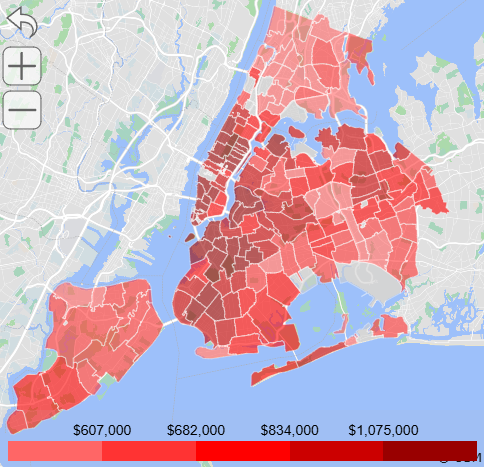

https://simplemaps.com/city/new-york/zips/home-value

Moran's i uses spatial lag which is just the average of neighbors. Dont use visual global as it can be misleading

as these metrics explain what not why, we need domain specific knowledge

marked points with features that are categorial, type is crime

ripleys G(d) basically just shows high population (find source high pop=high crime)


deep researche: which epsg to use and why